[View in Colaboratory](https://colab.research.google.com/github/gitgash/test_qa/blob/master/test_estimator.ipynb)

# Introduction
This work have been proceed as test job for quantitative analyst.  
Requirements:  
get [train data](https://www.dropbox.com/s/2hqoisbqzzgym26/train.csv?dl=1) 
get [test data](https://www.dropbox.com/s/y9tbmdqtlclobgp/test.csv?dl=1) 
get [Sample prediction](https://www.dropbox.com/s/r5qu2ornfinrt1s/sample_prediction.csv?dl=1) 

and make estimator with highest AUC ROC metric.  

During  this work it have been done: 
1. data exploration,
1. 'traditional' model creation 
1. artificial neural network model creation.

Results considered in conclusion section.  
Google (tm) [Colab.research](https://colab.research.google.com) have been used in this work, but methodology and technology (jupyter notebook) tools can be used in any suitable environment (python, scikit learn, pandas, numpy, tensorflow, keras).  
Style of the work is reproducible  - anybody can run this notebook and reproduce results.  
So lets start.

# Data Exploration
In process of data exploration following steps have been proceed:
1. Loading data
1. Simple exploration
1. Correlation analysis


## Load data
Data file have been place to dropbox so we load them from there by url.

In [0]:
# It is preleminary section where we include part of libraries used later 
# and define utility functions
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools


# Plot confision matrix function
# (c) by scikit lear documentation and examples
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

We use side library to upsample imbalanced test set (later explained) - so we need to install it:

In [2]:
!pip install -U imbalanced-learn

    100% |████████████████████████████████| 153kB 12.2MB/s 


In [0]:
# load dataset into pandas dataframe

train_df = pd.read_csv("https://www.dropbox.com/s/2hqoisbqzzgym26/train.csv?dl=1")
test_df = pd.read_csv("https://www.dropbox.com/s/y9tbmdqtlclobgp/test.csv?dl=1")
sample_df = pd.read_csv("https://www.dropbox.com/s/r5qu2ornfinrt1s/sample_prediction.csv?dl=1")

## Simple data exploration

In [4]:
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186590 entries, 0 to 186589
Data columns (total 21 columns):
VASK0         186590 non-null int64
VASK1         186590 non-null int64
VASK2         186590 non-null int64
VASK3         186590 non-null int64
VASK4         186590 non-null int64
VBID0         186590 non-null int64
VBID1         186590 non-null int64
VBID2         186590 non-null int64
VBID3         186590 non-null int64
VBID4         186590 non-null int64
VASK0_PREV    186590 non-null int64
VASK1_PREV    186590 non-null int64
VASK2_PREV    186590 non-null int64
VASK3_PREV    186590 non-null int64
VASK4_PREV    186590 non-null int64
VBID0_PREV    186590 non-null int64
VBID1_PREV    186590 non-null int64
VBID2_PREV    186590 non-null int64
VBID3_PREV    186590 non-null int64
VBID4_PREV    186590 non-null int64
Y             186590 non-null int64
dtypes: int64(21)
memory usage: 29.9 MB


,VASK0,VASK1,VASK2,VASK3,VASK4,VBID0,VBID1,VBID2,VBID3,VBID4,...,VASK1_PREV,VASK2_PREV,VASK3_PREV,VASK4_PREV,VBID0_PREV,VBID1_PREV,VBID2_PREV,VBID3_PREV,VBID4_PREV,Y
0,108,276,224,196,195,132,181,253,207,185,...,276,224,196,195,136,181,253,207,185,0
1,47,132,197,236,188,81,146,193,169,192,...,132,197,236,188,81,146,193,169,192,0
2,93,172,193,226,232,33,128,168,145,140,...,172,193,226,232,33,128,168,145,140,0
3,62,104,169,188,140,75,165,151,206,105,...,104,169,188,140,81,165,151,206,105,0
4,40,43,87,110,99,11,66,77,155,364,...,43,87,110,99,11,66,77,153,364,0


186590 examples -  not bad for deep learning  
'Y' column contains label.  
21 columns, 1 - label so we have 20 features.  
Features are finteger  
Lets look on the features: 

In [6]:
# Looking for names
for s in train_df.columns[0:-1]:
    print("%s\t%d" % (s, train_df[s].count()))

VASK0	186590
VASK1	186590
VASK2	186590
VASK3	186590
VASK4	186590
VBID0	186590
VBID1	186590
VBID2	186590
VBID3	186590
VBID4	186590
VASK0_PREV	186590
VASK1_PREV	186590
VASK2_PREV	186590
VASK3_PREV	186590
VASK4_PREV	186590
VBID0_PREV	186590
VBID1_PREV	186590
VBID2_PREV	186590
VBID3_PREV	186590
VBID4_PREV	186590


As been said in description there are top 5 bids and asks for current time and previous moment.     
No NaN values in columns.   
What about labels?  

count    186590.000000
mean          0.010258
std           0.100760
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Y, dtype: float64


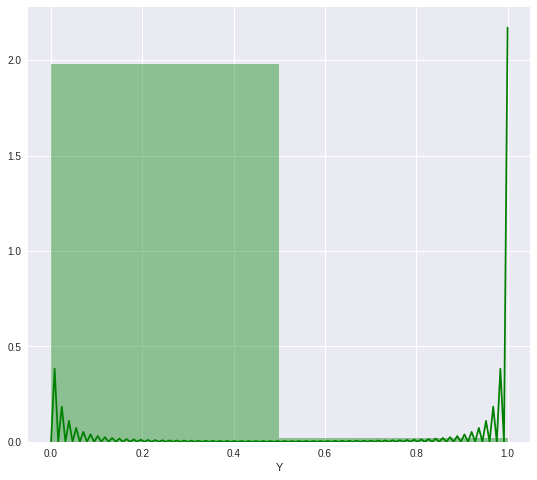

In [7]:
print(train_df['Y'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(train_df['Y'], color='g', bins=2, hist_kws={'alpha': 0.4});

Labels are strongly imbalanced: class '1' prevails over 0.  


# Correlation analisys

In [8]:
# calculate correlation matrix and get 'label' correlation column
df_num_corr = train_df.corr()['Y'][:-1]
# get absolute value of correlation
abs_corr = abs(df_num_corr)
# sort and get top 20
abs_corr.sort_values(ascending=False).head(20)

VBID0         0.025155
VASK0         0.024026
VBID0_PREV    0.023590
VASK0_PREV    0.022126
VBID1         0.007163
VBID1_PREV    0.007082
VBID3_PREV    0.006144
VBID3         0.006133
VASK1         0.005619
VASK1_PREV    0.005569
VASK4_PREV    0.004739
VASK4         0.004727
VASK3         0.004548
VASK3_PREV    0.004537
VASK2         0.004106
VASK2_PREV    0.004067
VBID2         0.003978
VBID2_PREV    0.003969
VBID4_PREV    0.003783
VBID4         0.003782
Name: Y, dtype: float64

Correlation is week

## What about test data?

In [10]:
test_df.head()

,VASK0,VASK1,VASK2,VASK3,VASK4,VBID0,VBID1,VBID2,VBID3,VBID4,VASK0_PREV,VASK1_PREV,VASK2_PREV,VASK3_PREV,VASK4_PREV,VBID0_PREV,VBID1_PREV,VBID2_PREV,VBID3_PREV,VBID4_PREV
0,187,341,385,375,323,134,158,213,222,180,187,341,385,375,323,134,158,212,222,180
1,37,165,144,160,146,89,101,184,162,123,38,165,144,160,146,89,101,185,162,123
2,195,192,211,178,188,18,114,162,163,167,195,192,211,178,188,18,114,162,163,167
3,5,180,143,159,194,109,127,224,133,132,5,180,143,159,194,110,127,224,133,132
4,117,156,154,169,139,48,129,148,159,177,117,156,154,169,139,48,128,148,159,177


No target - the rest is the same as train

## What about sample?

In [11]:
sample_df.head()

,Y_PRED
0,0.0
1,0.5
2,1.0
3,0.0
4,0.5


Y_PRED have to be float - as beleive of value to be 1

# Build Estimators

Lets make train and test dataset

In [0]:
# crete X and y
X = train_df.iloc[:,0:-1].copy()
y = train_df['Y']

# divide to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=3623467829)

Ground floor estimator

In [17]:
from sklearn.dummy import DummyClassifier

# calculate ground floor for stratified dummy classifier
clf = DummyClassifier(strategy='stratified',random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
print("F1 dummy stratified  %f" % roc_auc_score(y_train, y_pred))

# calculate ground flow for most_frequent dummy classifier
clf = DummyClassifier(strategy='most_frequent',random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
print("F1 dummy most frequent  %f" % roc_auc_score(y_train, y_pred))



F1 dummy stratified  0.501272
F1 dummy most frequent  0.500000


Bad estimator give us 0.5 AUC_ROC metric

## Traditional estimator

In [0]:
# import requried modules
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

fix 'ho free space' error:

In [0]:
import os
os.environ['JOBLIB_TEMP_FOLDER']='/tmp'

Technical dilemma: its impossible to reproduce fitting metaparameters process on chosen environment - google colab timed out if we try grid_search for given case.  
Decision  implemented: run grid_search on controlled environment and then put optimal params to google colab notebook to keep research reproducible.  
grid_search code commented out bellow.

In [0]:
# balance training set by oversampling
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train)
from collections import Counter
print(sorted(Counter(y_resampled).items()))


# preprocess features
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# create emty params to fill later
params = {}

# SVM
svm = SVC(kernel='rbf')
params['svm__gamma'] = [0.005, 0.01, 0.05]

# define pipeline
pipeline = Pipeline([
    ('svm', svm),
])

grid_search = GridSearchCV(pipeline, params, n_jobs=-1, verbose=1)

print("Start fitting...")
t0 = time()
grid_search.fit(X_resampled, y_resampled)

print("done in %0.3fs" % (time() - t0))

[(0, 166211), (1, 166211)]
Start fitting...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


F1 dummy most_frequent weighted score 0.388760
F1 dummy most_frequent macro score 0.265831
Confusion matrix, without normalization
[[ 62  13  25  27 128]
 [ 23   6  16  21  85]
 [ 36  18  68  78 171]
 [ 46  13  72 154 413]
 [ 91  33 101 248 865]]


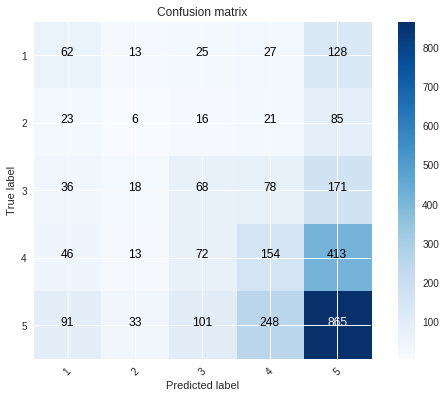

In [0]:
# print best estimator params
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
# result evalution
y_pred = grid_search.best_estimator_.predict(X_test)

print("F1 dummy stratified  %f" % roc_auc_score(y_test, y_pred))
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix,[1,2])

Macro score is 0.265831, weighted score is 0.388760.  
This is a little  better then dummy classifier macro score 0.212425 and weighted score 0.323443.  



## Artificial Neural Networks estimator

In ANN estimator keros framework have been used.  
CNN shows good results in DNN for image classifications, LSTM good for timeseries and queued events (like words in sentense) but in our case we have just array of features with unknown nature.  
So chosen architecture is relatively shallow set of fully connected layers interlaced by dropout layers.  
there are several parameters to play with: number of layers, size of layers, dropout value.  
Below  is result of our several tries to make effective architecture.

In [0]:
# crete X and y
X = df.iloc[:,1:-1].copy()
y = keras.utils.to_categorical(df['label'] - 1, num_classes=5)

# divide to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=3623467829)
# preprocess features
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
pca = PCA(n_components=512)
pca.fit(X_train)
X_train = pca.transform(X_train)

# balance train set
X_resampled, y_resampled = SMOTE().fit_sample(X_train, np.argmax(y_train, 1))
X_train = X_resampled
y_train = keras.utils.to_categorical(y_resampled, num_classes=5)
from collections import Counter
print(sorted(Counter(y_resampled).items()))


[(0, 12181), (1, 12181), (2, 12181), (3, 12181), (4, 12181)]


In [0]:
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=512))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

model.fit(X_train, y_train,
          epochs=100,
          batch_size=128)



Epoch 1/100
60905/60905 [==============================] - 34s 562us/step - loss: 1.5242 - acc: 0.3137
Epoch 2/100
60905/60905 [==============================] - 32s 528us/step - loss: 1.4632 - acc: 0.3548
Epoch 3/100
60905/60905 [==============================] - 32s 531us/step - loss: 1.4081 - acc: 0.3930
Epoch 4/100
60905/60905 [==============================] - 32s 533us/step - loss: 1.3404 - acc: 0.4326
Epoch 5/100
60905/60905 [==============================] - 33s 537us/step - loss: 1.2728 - acc: 0.4654
Epoch 6/100
60905/60905 [==============================] - 33s 537us/step - loss: 1.2056 - acc: 0.4990
Epoch 7/100
60905/60905 [==============================] - 33s 538us/step - loss: 1.1464 - acc: 0.5230
Epoch 8/100
60905/60905 [==============================] - 32s 533us/step - loss: 1.0856 - acc: 0.5491
Epoch 9/100
60905/60905 [==============================] - 32s 523us/step - loss: 1.0366 - acc: 0.5707
Epoch 10/100
60905/60905 [==============================] - 32s 532us/ste

In [0]:
# make prediction on test set
X_test_2 = pca.transform(scaler.transform(X_test))

y_pred = model.predict(X_test_2)
# calculate f1 weighted score
score = model.evaluate(X_train, y_train, batch_size=128)
print("Score = %f" % score[1])
print("F1 weighted score %f" % f1_score(np.argmax(y_test, 1), np.argmax(y_pred, 1), average='weighted'))
print("F1 macro score %f" % f1_score(np.argmax(y_test, 1), np.argmax(y_pred, 1), average='macro'))

60905/60905 [==============================] - 8s 130us/step
Score = 0.996848
F1 weighted score 0.375937
F1 macro score 0.278116


Macro score is 0.278116, weighted score is 0.375937.  
This is a little  better then dummy classifier macro score 0.212425 and weighted score 0.323443.  



Confusion matrix, without normalization
[[ 73  25  38  54  65]
 [ 19  12  30  44  46]
 [ 32  19  80 107 133]
 [ 46  28 113 229 282]
 [ 65  49 196 385 643]]


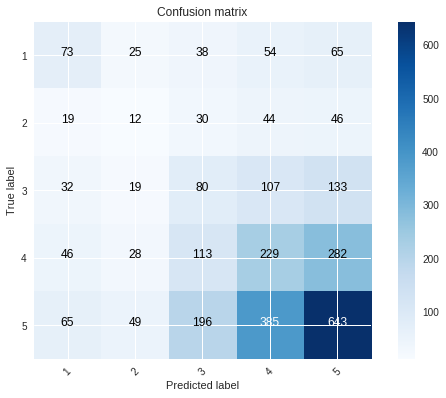

In [0]:
cnf_matrix = confusion_matrix(np.argmax(y_test, 1), np.argmax(y_pred, 1))
plot_confusion_matrix(cnf_matrix,[1,2,3,4,5])

Stacking binary classifiers with shallow multiclass classifier
===============================================

In [0]:
models = []
train_data = np.empty_like(y_train)
for i in range(0,5):  
  bmodel = Sequential()
  bmodel.add(Dense(512, activation='relu', input_dim=512))
  bmodel.add(Dropout(0.2))
  bmodel.add(Dense(1024, activation='relu'))
  bmodel.add(Dropout(0.2))
  bmodel.add(Dense(1024, activation='relu'))
  bmodel.add(Dropout(0.2))
  bmodel.add(Dense(512, activation='relu'))
  bmodel.add(Dropout(0.2))
  bmodel.add(Dense(1, activation='sigmoid'))
  sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  bmodel.compile(loss='binary_crossentropy',
                optimizer=sgd,
                metrics=['accuracy'])
  bmodel.fit(X_train, (np.argmax(y_train, 1)==i)+0,
            epochs=30,
            batch_size=128)
  models.append(bmodel)
  r = bmodel.predict(X_train)
  train_data[:,i] = r.reshape(1, len(r))



Epoch 1/30
60905/60905 [==============================] - 31s 513us/step - loss: 0.4528 - acc: 0.8035
Epoch 2/30
60905/60905 [==============================] - 31s 507us/step - loss: 0.4185 - acc: 0.8148
Epoch 3/30
60905/60905 [==============================] - 31s 506us/step - loss: 0.3923 - acc: 0.8234
Epoch 4/30
60905/60905 [==============================] - 31s 509us/step - loss: 0.3668 - acc: 0.8341
Epoch 5/30
60905/60905 [==============================] - 31s 508us/step - loss: 0.3384 - acc: 0.8485
Epoch 6/30
60905/60905 [==============================] - 31s 507us/step - loss: 0.3086 - acc: 0.8612
Epoch 7/30
60905/60905 [==============================] - 31s 505us/step - loss: 0.2857 - acc: 0.8739
Epoch 8/30
60905/60905 [==============================] - 31s 503us/step - loss: 0.2617 - acc: 0.8856
Epoch 9/30
60905/60905 [==============================] - 30s 500us/step - loss: 0.2434 - acc: 0.8942
Epoch 10/30
60905/60905 [==============================] - 30s 493us/step - loss: 

In [0]:
mmodel = Sequential()
mmodel.add(Dense(5, activation='relu', input_dim=5))
mmodel.add(Dropout(0.2))
mmodel.add(Dense(10, activation='relu'))
mmodel.add(Dropout(0.2))
mmodel.add(Dense(5, activation='softmax'))

mmodel.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
mmodel.fit(train_data, y_train,
          epochs=20,
          batch_size=128)

Epoch 1/20
60905/60905 [==============================] - 2s 35us/step - loss: 1.1925 - acc: 0.5362
Epoch 2/20
60905/60905 [==============================] - 1s 17us/step - loss: 0.8011 - acc: 0.7037
Epoch 3/20
60905/60905 [==============================] - 1s 17us/step - loss: 0.6764 - acc: 0.7562
Epoch 4/20
60905/60905 [==============================] - 1s 16us/step - loss: 0.5962 - acc: 0.7863
Epoch 5/20
60905/60905 [==============================] - 1s 16us/step - loss: 0.5443 - acc: 0.8008
Epoch 6/20
60905/60905 [==============================] - 1s 16us/step - loss: 0.5226 - acc: 0.8104
Epoch 7/20
60905/60905 [==============================] - 1s 16us/step - loss: 0.5074 - acc: 0.8232
Epoch 8/20
60905/60905 [==============================] - 1s 17us/step - loss: 0.4948 - acc: 0.8277
Epoch 9/20
60905/60905 [==============================] - 1s 17us/step - loss: 0.4902 - acc: 0.8272
Epoch 10/20
60905/60905 [==============================] - 1s 18us/step - loss: 0.4834 - acc: 0.8281

In [0]:
# make prediction on test set
X_test_2 = pca.transform(scaler.transform(X_test))

test_data = np.empty_like(y_test)
for i in range(0,5):  
  r = models[i].predict(X_test_2)
  test_data[:,i] = r.reshape(1, len(r))

y_pred = mmodel.predict(test_data)

F1 weighted score 0.386277
F1 macro score 0.272772
Confusion matrix, without normalization
[[ 78  33  34  37  73]
 [ 29   9  24  35  54]
 [ 35  21  53 104 158]
 [ 51  20  94 221 312]
 [ 75  39 160 336 728]]


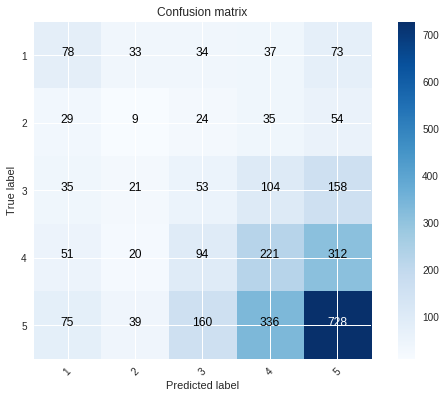

In [0]:
print("F1 weighted score %f" % f1_score(np.argmax(y_test, 1), np.argmax(y_pred, 1), average='weighted'))
print("F1 macro score %f" % f1_score(np.argmax(y_test, 1), np.argmax(y_pred, 1), average='macro'))
cnf_matrix = confusion_matrix(np.argmax(y_test, 1), np.argmax(y_pred, 1))
plot_confusion_matrix(cnf_matrix,[1,2,3,4,5])

Macro score is 0.272772, weighted score is 0.386277.  
This is a liittle better then dummy classifier macro score 0.212425 and weighted score 0.323443.  

# Conclusion

Following result have been achieved:


| Mode \ Target     |   Macro F1   |   Weighted F1  |  
| -------------------------   | ------------------: |  --------------------: |  
| SVM Classifier    |  0.265831     |       0.388760  |  
| ANN Classifier    |  0.278116     |       0.375937  |  
| Stacked Classifier    |  0.272772     |      0.386277  |  

SVM classifier shows best weighted f1 metric.  
ANN classifier shows best macro f1 metric.  

But all result not much better than dummy classifiers ( macro score 0.212425 and weighted score 0.323443).  
Cause of such a result may be week classifiers tuned during this work or absence of dependence between presented features and labels (which is indirectly confirmed by low correlation).  
Macto f1 metric is more general so ANN Classifier is the best for 5 classes.






# Future work
Presumably neural network approach can provide better results.  
Key development directions:  
1. Try deep architectures with [regularizers](https://keras.io/regularizers/)
1. Make CNN with convolutions based on 'fX__rY - groups of features. Convolutions in image classification extruct base features from 2d-local regions, so hypotheses  is to extract  base features of provided data from fX groups of features (that presumably grouped in some space)
1. Fit autoencoders on fX__rY groups of features and use them as input layer for 2-3 fully connected layers

# 2 classes classifier
Lets make ANN classifier for 2 classes dataset

In [0]:
# select 2 classes (1 and 5) subset
df2 = df[df['label'].isin([1, 5])].copy()
df2.loc[df2.label == 5, 'label'] = 2

# crete X and y
X = df2.iloc[:,1:-1].copy()
y = df2['label'] - 1

# divide to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=3623467829)

# preprocess features
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
pca = PCA(n_components=512)
pca.fit(X_train)
X_train = pca.transform(X_train)

# balance train set
# from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
from collections import Counter
X_resampled, y_resampled = SMOTEENN().fit_sample(X_train, y_train)
X_train = X_resampled
y_train = y_resampled

In [0]:
# model
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=512))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
model.fit(X_train, y_train, epochs=30, batch_size=128)

Epoch 1/30
18383/18383 [==============================] - 3s 158us/step - loss: 0.3947 - acc: 0.8194
Epoch 2/30
18383/18383 [==============================] - 2s 97us/step - loss: 0.2590 - acc: 0.8984
Epoch 3/30
18383/18383 [==============================] - 2s 97us/step - loss: 0.1720 - acc: 0.9365
Epoch 4/30
18383/18383 [==============================] - 2s 96us/step - loss: 0.1125 - acc: 0.9602
Epoch 5/30
18383/18383 [==============================] - 2s 97us/step - loss: 0.0881 - acc: 0.9696
Epoch 6/30
18383/18383 [==============================] - 2s 97us/step - loss: 0.0649 - acc: 0.9774
Epoch 7/30
18383/18383 [==============================] - 2s 97us/step - loss: 0.0484 - acc: 0.9828
Epoch 8/30
18383/18383 [==============================] - 2s 96us/step - loss: 0.0489 - acc: 0.9850
Epoch 9/30
18383/18383 [==============================] - 2s 96us/step - loss: 0.0383 - acc: 0.9881
Epoch 10/30
18383/18383 [==============================] - 2s 96us/step - loss: 0.0337 - acc: 0.988

F1  score 0.912137
Confusion matrix, without normalization
[[   5  255]
 [   2 1334]]


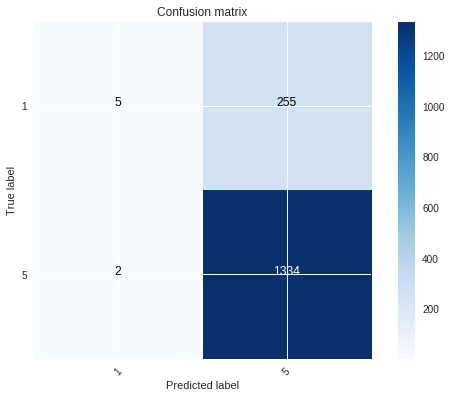

In [0]:
# make prediction on test set
X_test_2 = pca.transform(scaler.transform(X_test))
y_pred = model.predict(X_test_2)
y_pred = np.ceil(y_pred)
print("F1  score %f" % f1_score(y_test, y_pred))
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix,[1,5])

Dual classes classification shows better result f1=0.912449 
It is usual behavior cause 2 classes classification usually better and simpler than multiclass one.  
But still difference is too big.  
Possible cause that its data labeled by classes 2,3 for 4 natively belongs to 5 or 1. So estimator confused by that wrong data.  
Another explanation: presented set imbalanced in 5 class. Oversampling cannot absolutely remove this problem and estimator learn not only by features but it learn distribution of classes also. So when we present imbalanced test set skewed to 5 class estimator gives very good result.
The last explanation I believe most of all.


